In [1]:
#필요한 모듈을 import 합니다.
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


#데이터 불러오기 위해 필요한 라이브러리
import os
import cv2    #open cv 파이썬 버전
from sklearn.preprocessing import LabelEncoder    #이미지의 이름을 수치화 하여 라벨링 하기 위함
from glob import glob    #디렉토리를 리스트로 불러옴


#모델에 필요한 라이브러리
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation
from tensorflow.keras.utils import to_categorical
#import h5py    #크고 복잡한 대용량 데이터를 저장하기 위한 파일 형식
                #         - 모델을 저장하기 위함


    
#L2 정규화(Ridge):모형의 복잡성은 가중치의 제곱합으로 표현
from tensorflow.keras.regularizers import l2

In [2]:
# 데이터 로드 함수
def img_load(local):
    img_paths = glob(local)
    data = []
    label = []
    
    for path in img_paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (125, 125))
        
        label.append(path.split('\\')[4])        
        data.append(img)
    
    le = LabelEncoder()
    label = le.fit_transform(label)
    
    #더 높은 정확도를 위해 train 이미지를 섞음
    np.random.seed(42)
    index = np.arange(len(data))
    np.random.shuffle(index)
    
    data = np.array(data)
    data = data[index[:]]
    label = label[index[:]]
    
    return data, label

In [3]:
(x_train, t_train) = img_load('C:\\Python\\data\\train\\*\\*')
(x_test, t_test) = img_load('C:\\Python\\data\\test\\*\\*')
print('x_tarin : ', np.shape(x_train))
print('t_tarin : ', np.shape(t_train))
print('x_test : ', np.shape(x_test))
print('t_test : ', np.shape(t_test))

x_tarin :  (3372, 125, 125, 3)
t_tarin :  (3372,)
x_test :  (847, 125, 125, 3)
t_test :  (847,)


In [4]:
print('x_train 1번째 이미지 shape : ', x_train[0].shape)
x_train[0]

x_train 1번째 이미지 shape :  (125, 125, 3)


array([[[246, 245, 241],
        [246, 245, 241],
        [247, 246, 242],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[247, 246, 242],
        [247, 246, 242],
        [247, 246, 242],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[248, 247, 243],
        [249, 248, 244],
        [249, 248, 244],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

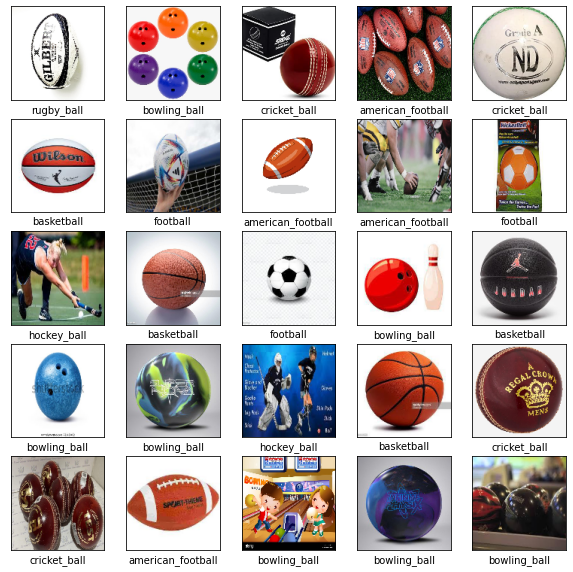

In [5]:
label_names = ['american_football', 'basketball', 'bowling_ball', 'cricket_ball', 'football', 'hockey_ball', 'rugby_ball']
plt.figure(figsize = (10, 10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i])
    plt.xlabel(label_names[t_train[i]])
plt.show()
    

In [6]:
(x_train, t_train) = img_load('C:\\Python\\data\\train\\*\\*')
(x_test, t_test) = img_load('C:\\Python\\data\\test\\*\\*')
print('x_train: ', np.shape(x_train))
print('t_train: ', np.shape(t_train))
print('x_test: ', np.shape(x_test))
print('t_test: ', np.shape(t_test))

x_train:  (3372, 125, 125, 3)
t_train:  (3372,)
x_test:  (847, 125, 125, 3)
t_test:  (847,)


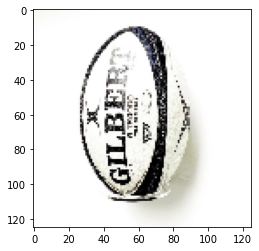

In [7]:
plt.imshow(x_train[0])
plt.show()

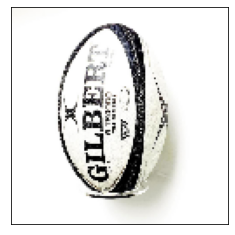

In [8]:
plt.xticks([])
plt.yticks([])
plt.imshow(x_train[0])
plt.show()

In [9]:
t_train

array([6, 2, 3, ..., 3, 2, 6], dtype=int64)

In [10]:
for i in range(5):
    print(t_train[i])

6
2
3
0
3


In [11]:
for i in range(5):
    print(t_train[i])

6
2
3
0
3


In [12]:
#정규화
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

#숫자 => One-hot Vector(Encoding)
t_train = to_categorical(t_train)
t_test = to_categorical(t_test)
print('One-hot Vector 적용 후 t_train shape : ', t_train.shape)
print('One-hot Vector 적용 후 t_test shape : ', t_test.shape)

One-hot Vector 적용 후 t_train shape :  (3372, 7)
One-hot Vector 적용 후 t_test shape :  (847, 7)


In [13]:
#높이, 너비, 채널(RGB) 설정
width = 125
height = 125
channel = 3

#순차적 모델을 만들기 위한 Sequential(함수)
model = Sequential(name ='SPORTSBALL_CNN')

#Convolution layer 와 MaxPooling layer를 통해 이미지 특징 추출
#Convolution layer=> filters : 필터 개수, kernel_size: 커널(필터) 크기
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'same', activation = 'relu',
                input_shape = (width, height, channel)))
#pool_size : MaxPooling의 Window size
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

#추출한 특징을 완전연결 계층(Dense)으로 전달하기 위해 Flatten 계층을 통해 1차원으로 변경
model.add(Flatten())

#출력층(완전연결 계층)
model.add(Dense(7, activation = 'softmax'))
#categorical_crossentropy는 분류할 클래스 3개 이상일 경우 사용
model.compile(loss = 'categorical_crossentropy', optimizer  =Adam(learning_rate = 0.001), metrics = ['accuracy'])
model.summary()



Model: "SPORTSBALL_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 128)   

In [14]:
#학습하기
model.fit(x_train, t_train, epochs = 10, batch_size = 16)

Epoch 1/10
211/211 [==============================] - 26s 119ms/step - loss: 1.7612 - accuracy: 0.3090
Epoch 2/10
211/211 [==============================] - 27s 128ms/step - loss: 1.4410 - accuracy: 0.4683
Epoch 3/10
211/211 [==============================] - 30s 140ms/step - loss: 1.1318 - accuracy: 0.6065
Epoch 4/10
211/211 [==============================] - 30s 143ms/step - loss: 0.8637 - accuracy: 0.7055
Epoch 5/10
211/211 [==============================] - 30s 143ms/step - loss: 0.5951 - accuracy: 0.8043
Epoch 6/10
211/211 [==============================] - 30s 144ms/step - loss: 0.3925 - accuracy: 0.8793
Epoch 7/10
211/211 [==============================] - 31s 146ms/step - loss: 0.2685 - accuracy: 0.9193
Epoch 8/10
211/211 [==============================] - 31s 146ms/step - loss: 0.1503 - accuracy: 0.9579
Epoch 9/10
211/211 [==============================] - 31s 148ms/step - loss: 0.1279 - accuracy: 0.9656
Epoch 10/10
211/211 [==============================] - 31s 149ms/step - l

1/1 [==============================] - 0s 189ms/step
예측 : bowling_ball\ 정답 : football


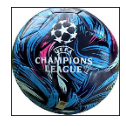

1/1 [==============================] - 0s 33ms/step
예측 : cricket_ball\ 정답 : cricket_ball


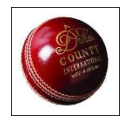

1/1 [==============================] - 0s 28ms/step
예측 : cricket_ball\ 정답 : bowling_ball


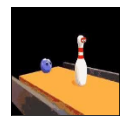

1/1 [==============================] - 0s 30ms/step
예측 : american_football\ 정답 : bowling_ball


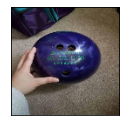

1/1 [==============================] - 0s 44ms/step
예측 : rugby_ball\ 정답 : rugby_ball


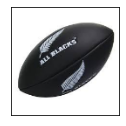

1/1 [==============================] - 0s 46ms/step
예측 : rugby_ball\ 정답 : rugby_ball


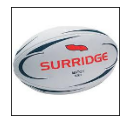

1/1 [==============================] - 0s 43ms/step
예측 : basketball\ 정답 : basketball


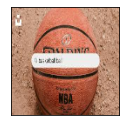

1/1 [==============================] - 0s 29ms/step
예측 : hockey_ball\ 정답 : hockey_ball


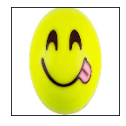

1/1 [==============================] - 0s 66ms/step
예측 : basketball\ 정답 : basketball


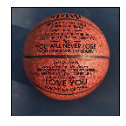

1/1 [==============================] - 0s 32ms/step
예측 : bowling_ball\ 정답 : hockey_ball


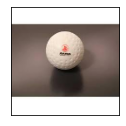

In [15]:
#높이, 너비, 채널 (RGB) 설정
width = 125
height = 125
channel = 3

#정답 레이블
label_name = ['american_football', 'basketball', 'bowling_ball', 'cricket_ball', 'football', 'hockey_ball', 'rugby_ball']

#10개의 test_data로 성능 확인
for i in range(10):
    #출력 이미지 크기 설정
    plt.figure(figsize= (2,2))
    
    #test data를 통한 예측
    output = model.predict(x_test[i].reshape(1, width, height, channel))
    #이미지 출력
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[i].reshape(width, height, channel))
    
    #np.argmax()는 labels의 인덱스(숫자)가 되어 label의 요소들(이름들)을 출력
    print('예측 : ' + label_names[np.argmax(output)] + '\ 정답 : '  + label_names[np.argmax(t_test[i])])
    plt.show()

In [16]:
loss, accuracy = model.evaluate(x_test, t_test, verbose=1)
print('test loss : ', round(loss, 6))
print('test accuracy : ', round(accuracy*100.3), '%')

27/27 [==============================] - 2s 62ms/step - loss: 2.8751 - accuracy: 0.5950
test loss :  2.875113
test accuracy :  60 %
